In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np

In [2]:
START_TRAIN_YEAR = "1998-01"
END_TRAIN_YEAR = "2018-12"
START_TEST_YEAR = "2019-01"
END_TEST_YEAR = "2025-12"

In [3]:
def split_train_test(dataset, start_train_date=START_TRAIN_YEAR, end_train_date=END_TRAIN_YEAR, start_test_date=START_TEST_YEAR, end_test_date=END_TEST_YEAR):
    train_data = dataset[(dataset["Year-Month"] >= start_train_date) & (dataset["Year-Month"] <= end_train_date)]
    test_data = dataset[(dataset["Year-Month"] >= start_test_date) & (dataset["Year-Month"] <= end_test_date)]

    return train_data.copy(), test_data.copy()

In [4]:
def standardize(train_X, test_X):
    scaler = StandardScaler()

    # Compute the mean and standard deviation of the training set
    scaler.fit(train_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'])

    # Transform the training and testing sets
    train_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'] = scaler.transform(train_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'])
    test_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'] = scaler.transform(test_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'])

    return train_X, test_X

In [5]:
input_dataset = pd.read_csv("dataset/model_dataset1998.csv").drop(["Unnamed: 0"], axis=1)

In [6]:
train_data, test_data = split_train_test(input_dataset)

train_date = train_data.pop("Year-Month")
test_date = test_data.pop("Year-Month")

train_X, train_y = train_data, train_data.pop('Wheat')
test_X, test_y = test_data, test_data.pop('Wheat')

model = LinearRegression(fit_intercept=True)

model.fit(train_X, train_y)

predictions = model.predict(train_X)

test_predictions = model.predict(test_X)

In [7]:
train_X = sm.add_constant(train_X)
sm_model = sm.OLS(train_y, train_X).fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Wheat   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     197.7
Date:                Wed, 14 May 2025   Prob (F-statistic):          7.99e-110
Time:                        17:53:15   Log-Likelihood:                -1384.4
No. Observations:                 251   AIC:                             2791.
Df Residuals:                     240   BIC:                             2830.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -907.8744    309.140     -2.937      0.004   -1516.849    -298.900
StckUse_US               -4.4001      0.684     -6.437      0.000      -5.747      -3.054
StckUse_World             1.6328      1.705      0.958      0.339      -1.726       4.992
Urea                      0.1533      0.066      2.320      0.021       0.023       0.283
WTI                       2.0978      0.345      6.077      0.000       1.418       2.778
Dollar                    0.8204      0.649      1.264      0.208      -0.458       2.099
MM_Net                    0.0012      0.000      8.518      0.000       0.001       0.001
MM_Categorical           12.3336     25.355      0.486      0.627     -37.614      62.281
Seasonality_Weight      926.2389    292.342      3.168      0.002     350.355    1502.123
Uncertain               -49.7063     16.774     -2.963      0.003     -82.750     -16.662
Business_Cycle_Weight   545.1976     63.449      8.593      0.000     420.209     670.187
==============================================================================
Omnibus:                       26.354   Durbin-Watson:                   0.388
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.761
Skew:                           0.383   Prob(JB):                     4.79e-18
Kurtosis:                       5.653   Cond. No.                     4.37e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
train_predictions = pd.DataFrame({"Predicted_price": predictions, "Year-Month": train_date})
test_predictions = pd.DataFrame({"Predicted_price": test_predictions, "Year-Month": test_date})

df_predictions = pd.concat([train_predictions, test_predictions])
full_dates = [datetime.strptime(date, '%Y-%m') for date in df_predictions["Year-Month"]]
train_dates = [datetime.strptime(date, '%Y-%m') for date in train_predictions["Year-Month"]]
test_dates = [datetime.strptime(date, '%Y-%m') for date in test_predictions["Year-Month"]]

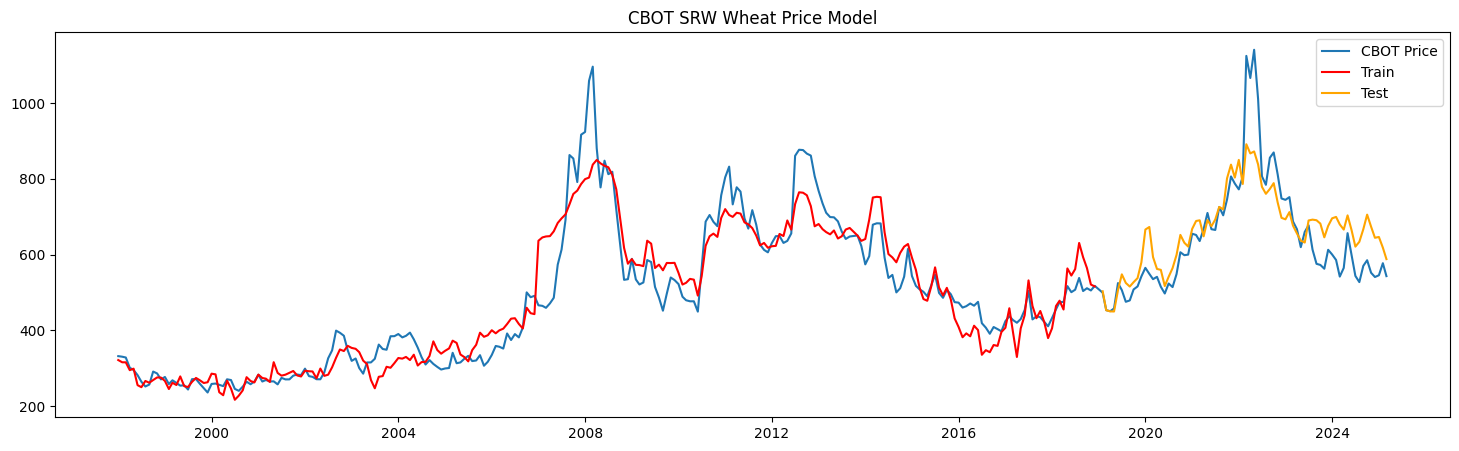

Last wheat average price as of 2025-03 : 543.17
Model prediction of wheat average price as of 2025-03 : 588.09


In [9]:
fig, ax = plt.subplots(figsize=(18, 5))
plt.plot(full_dates, input_dataset["Wheat"], label="CBOT Price")
plt.plot(train_dates, train_predictions["Predicted_price"], label="Train", color="red")
plt.plot(test_dates, test_predictions["Predicted_price"], label="Test", color="orange")
plt.title("CBOT SRW Wheat Price Model")
plt.legend()
plt.show()

print(f"Last wheat average price as of {input_dataset['Year-Month'].iloc[-1]} : {input_dataset['Wheat'].iloc[-1]:.2f}")
print(f"Model prediction of wheat average price as of {test_predictions['Year-Month'].iloc[-1]} : {test_predictions['Predicted_price'].iloc[-1]:.2f}")

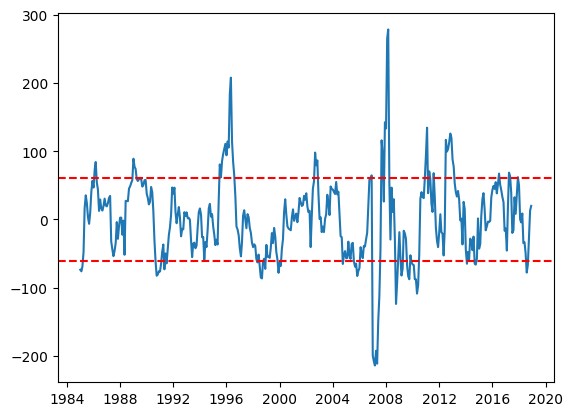

In [34]:
resid = pd.DataFrame({"Date": train_dates, "Resid": sm_model.resid})
plt.plot(resid["Date"], resid["Resid"])
plt.axhline(resid["Resid"].std(), color='red', linestyle='--')
plt.axhline(-resid["Resid"].std(), color='red', linestyle='--')

In [31]:
sm_model.resid

0     -73.605061
1     -75.924822
2     -69.006217
3     -47.712159
4      16.355474
         ...    
403   -77.803749
404   -66.191333
405   -27.732657
406    12.763778
407    19.859935
Length: 408, dtype: float64